In [1]:
import torch
import numpy as np
from transformers import GPT2Config
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

device = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(device)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['HF_HOME'] = "/scratch/cluster/vansh/hf_cache"

from data.dataset import CustomTokenizer
from data.sibling import make_dataset
from model.networks import AttentionOnlyLMHeadModel
from model.eval import decode_batch, generate_samples
from model.train import train_main
from model.utils import set_seed
from data.dataset import collate_fn

# %%
DEVICE = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

/scratch/cluster/vansh/miniconda/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# define dataset parameters
dataset_name = "sibling"
model_type = "gpt2-custom"
model_path = None

P = 5
C = 2500
H = 26
HL = 20
prob = 1.0
seed_per_pi = False
num_train_samples =10000
batch_size = 64
num_eval_samples = 1000
eval_batch_size = 256
num_ckpts = 20
epochs = 30
eval_runs = 1
top_p=1.0
save_name = f"P{P}-C{C}-H{H}-NT{num_train_samples}-E{epochs}-top_p{top_p}-{model_type}"
data_root = f"/datastor1/vansh/lang_sampling/data"
regenerate_data = False
no_planning = False

n_embed=768
n_layer=4
n_head=3

In [7]:
from types import SimpleNamespace
args = SimpleNamespace(model_type=model_type)
print(model_type)

gpt2-custom


In [8]:
from model.utils import get_model, get_tokenizer

tokenizer = get_tokenizer(args, DEVICE, custom=False)
train_dataset, test_dataset, pretrain_dataset, train_strs, tokenized_graph, SEED_TOKENS, EVAL_TOKENIZER, prefixes = make_dataset(P=P,
                                                                                                                                    C=C,
                                                                                                                                    H=H,
                                                                                                                                    seed_len=HL,
                                                                                                                                    edge_prob=prob,
                                                                                                                                    pretrain_adjacency=True,
                                                                                                                                    planning=True,
                                                                                                                                    fixed=True,
                                                                                                                                    num_train_samples=num_train_samples,
                                                                                                                                    num_test_samples=num_eval_samples,
                                                                                                                                    tokenizer=tokenizer,
                                                                                                                                    data_root=data_root,
                                                                                                                                    regenerate=regenerate_data,
                                                                                                                                    add_new_tokens=True)

data_collator = lambda features: collate_fn(features, tokenizer=tokenizer)

BOS token: <BOS>, ID: 52762
EOS token: <EOS>, ID: 52763
PAD token: <EOS>, ID: 52763
Loading existing dataset from /datastor1/vansh/lang_sampling/data/sibling/P5-C2500-fixed-planning
Pre-calculating all training seeds...
Pre-calculating all training seeds...


In [ ]:
from transformers import AutoModelForCausalLM

# model = AutoModelForCausalLM.from_pretrained(
#             "google/gemma-2b",
#             cache_dir="/scratch/cluster/vansh/hf_cache",
#             torch_dtype=torch.bfloat16,
#             attn_implementation="eager",
#             ).to(DEVICE)
model = get_model(args, tokenizer, DEVICE, n_embed=n_embed, n_layer=n_layer, n_head=n_head)
model.resize_token_embeddings(len(tokenizer))


Initializing new gpt2-custom model


Embedding(52792, 768)

In [10]:
print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

Model has 69,683,712 trainable parameters



--- Running Learning Rate Finder ---


 96%|█████████▌| 96/100 [00:08<00:00, 11.97it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.98E-05


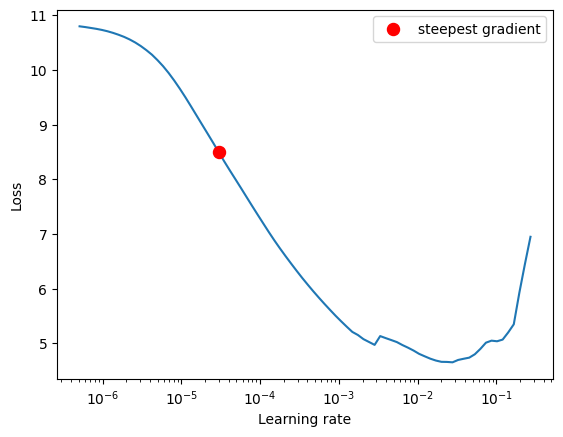

LR Finder plot saved to lr_finder.png

--- LR Finder complete. You can now use the suggested LR for training. ---


In [11]:
from torch_lr_finder import LRFinder, TrainDataLoaderIter
import torch.optim as optim
import torch.nn as nn

class HFTrainLoaderIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return batch_data, batch_data["labels"]

class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs):
        return self.model(**inputs)

def hf_criterion(outputs, labels):
    return outputs.loss


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, # Use the same batch size as your main training
    collate_fn=data_collator,
    shuffle=True
)


# --- LR Finder ---
print("\n--- Running Learning Rate Finder ---")

# 1. Wrap the model
wrapped_model = ModelWrapper(model)

# 2. Define optimizer
optimizer = optim.Adam(wrapped_model.parameters(), lr=1e-7, weight_decay=0.01)

# 3. Wrap the DataLoader
hf_train_iter = HFTrainLoaderIter(train_loader)

# 4. Initialize and run the finder
lr_finder = LRFinder(wrapped_model, optimizer, hf_criterion, device=DEVICE)
lr_finder.range_test(hf_train_iter, end_lr=1, num_iter=100)

# 5. Plot and reset
lr_finder.plot() # Saves lr_finder.png
print("LR Finder plot saved to lr_finder.png")
lr_finder.reset()

print("\n--- LR Finder complete. You can now use the suggested LR for training. ---")



In [12]:
tokenizer.decode([3])

'$'

In [13]:
train_dataset.strings[:5]

['c444 c1410 p0',
 'c172 c782 p2',
 'c2090 c2294 p3',
 'c961 c430 p2',
 'c184 c1770 p0']

In [14]:
collate_fn([train_dataset[0], train_dataset[3]], tokenizer=tokenizer)

{'input_ids': tensor([[52762, 52789, 52787, 52769, 52779, 52777, 52786, 52789, 52784, 52785,
          52788, 52768, 52783, 52765, 52779, 52766, 52779, 52779, 52769, 52765,
          52786, 52791,   220, 50706,   220, 51672,   220, 50257, 52763],
         [52762, 52764, 52780, 52776, 52774, 52768, 52764, 52770, 52768, 52784,
          52764, 52773, 52789, 52765, 52779, 52775, 52783, 52768, 52785, 52785,
          52765, 52791,   220, 51223,   220, 50692,   220, 50259, 52763]]),
 'labels': tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,   220, 50706,   220, 51672,   220, 50257, 52763],
         [ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,   220, 51223,   220, 50692,   220, 50259, 52763]]),
 'attention_mask': tensor([[1, 1, 1, 

In [15]:
tokenizer.decode([2509, 2536, 2534, 2516, 2526, 2524, 2533, 2536, 2531, 2532, 2535, 2515,
          2530, 2512, 2526, 2513, 2526, 2526, 2516, 2512, 2533, 2538,  453, 1419,
             4, 2510])
# tokenizer.decode([662, 1729,    4, 2510])

'iddlestr 22nes risk siteirmstr Spe challitting�iding block risk walk risk risknes blockirmLEallyoney%rael'

In [16]:
train_main(
    model=model,
    dataset_name=dataset_name,
    save_name=save_name,
    batch_size=batch_size,
    num_epochs=epochs,
    temperatures=[0.3, 0.5, 0.7, 1.0, 2.0],
    num_eval_runs=eval_runs,
    train_dataset=train_dataset,
    data_collator=data_collator,
    device=DEVICE,
    decode_fn=None,
    eval_fn=None,
    num_checkpoints=num_ckpts,
    log_to_wandb=False,
    save_results=False, 
    lr=1e-4
)

{'loss': 4.5028, 'grad_norm': 1.8229368925094604, 'learning_rate': 9.959660297239916e-05, 'epoch': 0.12738853503184713}
{'loss': 3.2534, 'grad_norm': 1.1265828609466553, 'learning_rate': 9.9171974522293e-05, 'epoch': 0.25477707006369427}
{'loss': 2.8923, 'grad_norm': 0.9365273118019104, 'learning_rate': 9.874734607218684e-05, 'epoch': 0.3821656050955414}
{'loss': 2.7253, 'grad_norm': 0.9240384697914124, 'learning_rate': 9.832271762208068e-05, 'epoch': 0.5095541401273885}
{'loss': 2.6428, 'grad_norm': 0.8454477190971375, 'learning_rate': 9.789808917197452e-05, 'epoch': 0.6369426751592356}
{'loss': 2.6104, 'grad_norm': 1.3252137899398804, 'learning_rate': 9.747346072186836e-05, 'epoch': 0.7643312101910829}
{'loss': 2.5602, 'grad_norm': 1.3464107513427734, 'learning_rate': 9.704883227176222e-05, 'epoch': 0.89171974522293}
{'loss': 2.4869, 'grad_norm': 1.350484848022461, 'learning_rate': 9.662420382165606e-05, 'epoch': 1.019108280254777}
{'loss': 2.3967, 'grad_norm': 3.4333784580230713, 'l

KeyboardInterrupt: 

In [17]:
# decode_sampling.py
import torch
from torch.utils.data import DataLoader, Subset
from transformers import PreTrainedTokenizer, PreTrainedModel, LogitsProcessor, LogitsProcessorList
import numpy as np
import random
import matplotlib.pyplot as plt
import os, math
from copy import copy
from functools import partial
from collections import defaultdict
from typing import List, Tuple

from data.dataset import collate_fn

def generate_input_prompt(bos_token, prefix, seed_tokens, seed_len, seen_seeds, conditional_prompt=""):
    """
    Generates a single input prompt with a unique seed, optionally followed by a conditional prompt.

    Args:
        bos_token (str): The beginning-of-sentence token.
        prefix (str): The task-specific prefix (e.g., "path").
        seed_tokens (list): The vocabulary of seed symbols.
        seed_len (int): The length of the seed sequence.
        seen_seeds (set): A set of seeds that have already been used.
        conditional_prompt (str, optional): The prompt to condition on. Defaults to "".

    Returns:
        str: The fully formatted input prompt for the model.
    """
    # Generate a novel seed that hasn't been seen in the training set
    novel_seed = ""
    if seed_len > 0:
        while True:
            h = "".join([random.choice(seed_tokens) for _ in range(seed_len)])
            if h not in seen_seeds:
                novel_seed = h
                seen_seeds.add(h)
                break
    
    # Combine the components: BOS, prefix, seed, and the conditional prompt
    parts = [bos_token + novel_seed + prefix, conditional_prompt]
    
    # Filter out any empty parts and join with spaces
    return " ".join(filter(None, parts))

class VocabMaskLogitsProcessor(LogitsProcessor):
    def __init__(self, vocab_mask_ids):
        self.vocab_mask_ids = vocab_mask_ids

    def __call__(self, input_ids, scores):
        scores[:, self.vocab_mask_ids] = -float("inf")
        return scores
    
def decode_batch(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    input_prompts: List[str],
    max_length: int,
    vocab_mask_ids: List[int] = None,
    greedy: bool = True,
    temperature: float = 1.0,
    top_p: float = 1.0,
) -> Tuple[List[str], List[torch.Tensor]]:
    """
    prefixes: List[str] — input prefix strings
    returns: Tuple[List[str], List[torch.Tensor]] — decoded completions, clipped at EOS, and their full token IDs (prompt + completion)
    """
    model.eval()

    encodings = tokenizer(
        input_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    input_ids = encodings["input_ids"].to(model.device)
    attention_mask = encodings["attention_mask"].to(model.device)
    
    prefix_lengths = attention_mask.sum(dim=1)
    
    logits_processors = None
    if vocab_mask_ids:
        logits_processors = LogitsProcessorList()
        #logits_processors.append(VocabMaskLogitsProcessor(vocab_mask_ids))

    generation_kwargs = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "do_sample": not greedy,
        "temperature": temperature,
        "top_k": 0,
        "top_p": top_p,
        "logits_processor": logits_processors,
        "pad_token_id": tokenizer.pad_token_id,
        "eos_token_id": tokenizer.eos_token_id,
        "max_length": max_length,
    }

    with torch.no_grad():
        outputs = model.generate(**generation_kwargs)

    # "Normalize" outputs by removing any left padding
    # After this step, every sequence in `unpadded_outputs` starts with a real token.
    unpadded_outputs = []
    if tokenizer.padding_side == "left":
        # Find the number of padding tokens at the beginning of each sequence
        # The first '1' in the attention mask marks the start of the real tokens
        num_left_pads = torch.argmax(attention_mask.to(torch.int), dim=1)
        for i, seq in enumerate(outputs):
            unpadded_outputs.append(seq[num_left_pads[i]:])
    else:
        # If padding is on the right, outputs are already "normalized"
        unpadded_outputs = list(outputs)

    # Now `unpadded_outputs` is a list of tensors, each starting with the real tokens.
    # and `prefix_lengths` is the correct length of the prompt for each sequence.
    generated_only = [
        seq[prefix_len:] for seq, prefix_len in zip(unpadded_outputs, prefix_lengths)
    ]

    eos_id = tokenizer.eos_token_id
    clipped_generated = [
        seq[:(seq == eos_id).nonzero(as_tuple=True)[0][0]] if eos_id in seq else seq
        for seq in generated_only
    ]

    # The logic for `clipped_outputs` is now also simpler and more robust,
    # as it operates on the unpadded sequences.
    clipped_outputs = [
        unpadded_seq[:prefix_len + len(clipped_seq) + 1] # include EOS
        for unpadded_seq, prefix_len, clipped_seq in zip(unpadded_outputs, prefix_lengths, clipped_generated)
    ]

    return tokenizer.batch_decode(clipped_generated, skip_special_tokens=True), clipped_outputs, prefix_lengths

def generate_samples(
    model, 
    dataset, 
    tokenizer, 
    decode_fn, 
    greedy, 
    seed_tokens, 
    seed_len, 
    max_length, 
    prefix="", 
    temperature=1.0, 
    top_p=1.0, 
    batch_size=8,
    conditional_prompts=None,
    num_conditional_samples=None,
    num_samples=100
):
    """
    Generates samples from a model, supporting both conditional and unconditional modes.

    Args:
        model: The transformer model.
        dataset: The dataset object containing training seeds.
        tokenizer: The tokenizer.
        decode_fn: The function to call for model generation and decoding.
        greedy (bool): Whether to use greedy decoding.
        seed_tokens (list): The vocabulary of seed symbols.
        seed_len (int): The length of the seed sequence.
        max_length (int): The maximum number of tokens to generate.
        prefix (str, optional): The task-specific prefix. Defaults to "".
        temperature (float, optional): Sampling temperature. Defaults to 1.0.
        top_p (float, optional): Nucleus sampling p-value. Defaults to 1.0.
        batch_size (int, optional): The batch size for generation. Defaults to 8.
        conditional_prompts (list, optional): A list of strings to condition on. If None,
                                              operates in unconditional mode. Defaults to None.
        num_conditional_samples (list, optional): A list of integers specifying how many samples
                                                  to generate for each conditional_prompt.
                                                  Required if conditional_prompts is not None.
        num_samples (int, optional): The total number of samples to generate in unconditional
                                     mode. Defaults to 100.

    Returns:
        tuple: A tuple containing a list of all generated samples and a list of raw model outputs.
    """
    model.eval()
    seen_seeds = copy(dataset.train_seeds)
    BOS = tokenizer.bos_token
    
    all_generated_samples = []
    prompts_to_process = []
    
    # --- Determine the list of prompts to process ---
    if conditional_prompts is not None:
        # Conditional Mode: Unroll the prompts into a single list
        if num_conditional_samples is None or len(conditional_prompts) != len(num_conditional_samples):
            raise ValueError("In conditional mode, 'num_conditional_samples' must be a list of the same length as 'conditional_prompts'.")
        
        print(f"\nCollating conditional prompts for efficient batching.")
        for prompt, count in zip(conditional_prompts, num_conditional_samples):
            prompts_to_process.extend([prompt] * count)
    else:
        # Unconditional Mode: Create a list of empty prompts
        print(f"\nGenerating {num_samples} unconditional samples.")
        prompts_to_process = [""] * num_samples
    # --- Process the prompts in batches ---
    num_processed = 0
    all_outputs = []
    all_input_lengths = []
    while num_processed < len(prompts_to_process):
        current_batch_size = min(batch_size, len(prompts_to_process) - num_processed)
        
        # Get the current batch of base prompts (e.g., ["v1 v10", "v1 v10", "v5 v25"])
        prompt_batch = prompts_to_process[num_processed : num_processed + current_batch_size]
        
        # Create the full input prompts with seeds for the model
        batch_input_list = [
            generate_input_prompt(BOS, prefix, seed_tokens, seed_len, seen_seeds, conditional_prompt=p)
            for p in prompt_batch
        ]

        # print(batch_input_list)
        
        # Generate samples for the batch
        vocab_mask_ids = tokenizer.convert_tokens_to_ids([BOS] + seed_tokens + [prefix])
        decoded_samples, outputs, input_lengths = decode_fn(model, tokenizer, batch_input_list, max_length, vocab_mask_ids, greedy, temperature, top_p)
        
        all_generated_samples.extend(decoded_samples)
        num_processed += len(decoded_samples)
        all_outputs.extend(outputs)
        all_input_lengths.extend(input_lengths.tolist())

    all_outputs = simple_collate_function(all_outputs, tokenizer)

    return all_generated_samples, all_outputs, all_input_lengths

def compute_perplexity(model, dataset, tokenizer, batch_size=512):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    collate_with_tokenizer = partial(collate_fn, tokenizer=tokenizer)
    
    # Create the DataLoader
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        collate_fn=collate_with_tokenizer,
        shuffle=False  # No need to shuffle for evaluation
    )
    
    with torch.no_grad():
        # Iterate over the correctly padded batches from the DataLoader
        for batch in dataloader:
            
            # Move the entire batch of padded tensors to the device
            input_ids = batch["input_ids"].to(model.device)
            labels = batch["labels"].to(model.device)
            attention_mask = batch["attention_mask"].to(model.device)
            
            # Pass attention_mask to the model, which is good practice
            outputs = model(input_ids=input_ids, labels=labels, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Your loss calculation logic is correct
            loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100, reduction='sum')
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
            num_tokens = (labels != -100).sum().item()
            
            total_loss += loss.item()
            total_tokens += num_tokens
    
    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity

def save_train_nll(
    model, 
    dataset, 
    tokenizer, 
    batch_size=32, 
    temperature=1.0,
    step=None,
    num_samples=None,
    nll_hist_path=None
):
    """
    Computes the per-sequence NLL for a given number of samples.

    Args:
        model: The model to evaluate.
        dataset: The full dataset.
        tokenizer: The tokenizer for the collate function.
        batch_size: The batch size for the DataLoader.
        num_samples: The number of samples to evaluate on. If None, uses the full dataset.
    """
    model.eval()
    
    # 1. Create a subset of the dataset if num_samples is specified
    if num_samples is not None:
        # Ensure we don't request more samples than are available
        num_samples = min(num_samples, len(dataset))
        eval_dataset = Subset(dataset, range(num_samples))
    else:
        eval_dataset = dataset
    
    neg_log_likelihoods = []

    collate_with_tokenizer = partial(collate_fn, tokenizer=tokenizer)
    dataloader = DataLoader(
        eval_dataset, 
        batch_size=batch_size, 
        collate_fn=collate_with_tokenizer,
        shuffle=False
    )
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(model.device)
            labels = batch["labels"].to(model.device)
            attention_mask = batch["attention_mask"].to(model.device)
            
            outputs = model(input_ids=input_ids, labels=labels, attention_mask=attention_mask)
            logits = outputs.logits / temperature
            
            # 1. Get per-token NLL by setting reduction to 'none'
            loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100, reduction='none')
            
            # The loss will have shape (batch_size * sequence_length)
            per_token_loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
            
            # 2. Reshape the loss to (batch_size, sequence_length)
            per_token_loss = per_token_loss.view(labels.shape)
            
            # 3. Sum the NLL for each sequence and divide by the true length
            # The label is -100 for padding and seed tokens, so we can use that to get the real loss
            per_sequence_loss = torch.where(labels != -100, per_token_loss, 0.0).sum(dim=1)
            num_tokens_per_sequence = (labels != -100).sum(dim=1)
            
            # Avoid division by zero for sequences that might be all padding
            # Although unlikely with truncation, this is a safe practice.
            num_tokens_per_sequence = torch.clamp(num_tokens_per_sequence, min=1)
            
            normalized_nll = per_sequence_loss / num_tokens_per_sequence
            
            # 4. Extend the list with the NLL for each sequence in the batch
            neg_log_likelihoods.extend(normalized_nll.tolist())
        
    if nll_hist_path is not None and step is not None:
        plt.figure(figsize=(10, 5))
        plt.hist(neg_log_likelihoods, bins=50, alpha=0.7, color='blue')
        plt.title('Distribution of Neg. Log Likelihoods @ Step {} and Temp {}'.format(step, temperature))
        plt.xlabel('Negative Log Likelihood')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.savefig(os.path.join(nll_hist_path, f"step_{step}_temp_{temperature}.png"))
        print(f"✅ NLL distribution saved at step {step}")
        plt.close()

    return 


def visualize_attention_weights(model, tokenizer, train_dataset, temperature, step, save_path, num_samples=100, max_length=20):
    """
    Generates sequences, gets per-head attention weights, and plots a grid of heatmaps
    for each head plus an average of all heads, with corrected subplot spacing.
    """
    model.eval()
    DEVICE = model.device
    print(f"\n--- Generating {num_samples} samples for attention analysis ---")
    
    # ... (The data generation and processing parts remain exactly the same as before) ...
    # 1. Generate samples and get their IDs and attention masks.
    with torch.no_grad():
        samples, full_outputs, input_lengths = generate_samples(
            model=model, 
            dataset=train_dataset, 
            tokenizer=tokenizer,
            decode_fn=decode_batch, 
            greedy=(temperature == 0.0), 
            seed_tokens=train_dataset.seed_tokens, 
            seed_len=train_dataset.seed_len, 
            max_length=max_length,
            temperature=temperature, 
            top_p=1.0, 
            num_samples=num_samples, 
            batch_size=250,
            prefix=train_dataset.prefix
        )

        rich_outputs = model(
            input_ids=full_outputs["input_ids"].to(DEVICE), 
            attention_mask=full_outputs["attention_mask"].to(DEVICE), 
            output_attentions=True
        )
        attentions = rich_outputs.attentions

    # 3. Get the attention tensor from the LAST layer.
    last_layer_attentions = attentions[-1].cpu()
    num_heads = last_layer_attentions.shape[1]
    
    # Efficiently find and average maps of the most common length
    seq_lengths = full_outputs["attention_mask"].sum(dim=1).cpu().numpy()
    unique_lengths, counts = np.unique(seq_lengths, return_counts=True)
    if len(unique_lengths) == 0:
        print("No samples generated. Cannot visualize attention.")
        return
    most_common_len = int(unique_lengths[np.argmax(counts)])
    indices_to_average = np.where(seq_lengths == most_common_len)[0]
    
    if len(indices_to_average) == 0:
        print(f"Could not find any samples with the most common length ({most_common_len}).")
        return

    print(f"Averaging attention maps for {len(indices_to_average)} samples of length {most_common_len}.")

    filtered_attentions = last_layer_attentions[indices_to_average, :, :most_common_len, :most_common_len].float()
    avg_per_head_map = filtered_attentions.mean(dim=0).float().numpy()
    overall_avg_map = avg_per_head_map.mean(axis=0)

    # --- REVISED VISUALIZATION LOGIC: Corrected spacing and colorbar placement ---
    
    n_plots = num_heads + 1
    ncols = int(math.ceil(math.sqrt(n_plots)))
    nrows = int(math.ceil(n_plots / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4.5)) # Adjusted figsize
    axes = axes.flatten()

    HL = train_dataset.seed_len
    input_tokens = ['<BOS>'] + [f"H{i+1}" for i in range(HL)]
    if train_dataset.prefix:
        input_tokens.append(train_dataset.prefix)

    readable_sequence = input_tokens + [f"T{i+1}" for i in range(most_common_len - len(input_tokens) - 1)] + ['<EOS>']

    # We need a reference to one of the heatmap image objects for the colorbar
    im = None 

    # Plot each head's average attention map
    for i in range(num_heads):
        ax = axes[i]
        im = ax.imshow(avg_per_head_map[i], cmap='viridis', vmin=0, vmax=np.max(avg_per_head_map)) # Use a dynamic vmax
        ax.set_title(f"Head {i}")
        ax.set_xticks(np.arange(len(readable_sequence)))
        ax.set_yticks(np.arange(len(readable_sequence)))
        ax.set_xticklabels(readable_sequence, rotation=90)
        ax.set_yticklabels(readable_sequence)

    # Plot the overall average attention map
    ax = axes[num_heads]
    # Use the same 'im' object to ensure the colorbar scale is consistent
    im = ax.imshow(overall_avg_map, cmap='viridis', vmin=0, vmax=np.max(avg_per_head_map))
    ax.set_title("Average of All Heads")
    ax.set_xticks(np.arange(len(readable_sequence)))
    ax.set_yticks(np.arange(len(readable_sequence)))
    ax.set_xticklabels(readable_sequence, rotation=90)
    ax.set_yticklabels(readable_sequence)

    # Hide any unused subplots
    for i in range(n_plots, len(axes)):
        axes[i].axis('off')

    # Add a main title for the entire figure
    fig.suptitle(f"Average Attention Heatmaps for Each Head\n{train_dataset.dataset_name}, HL={HL}, {len(indices_to_average)} samples", fontsize=16)

    # --- SPACING AND COLORBAR FIX ---
    # 1. Manually adjust the layout. 
    # `hspace` adds vertical space between rows to prevent titles from overlapping x-axis labels.
    # `right` shrinks the subplot area to make a dedicated space for the colorbar on the right.
    fig.subplots_adjust(hspace=0.6, right=0.88)

    # 2. Create a new, dedicated axis for the colorbar in the space we just created.
    # The arguments are [left, bottom, width, height] in figure-relative coordinates.
    # This prevents the colorbar from overlapping the plots.
    cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cax, label="Attention Weight")
    # --- END OF FIX ---
    
    # Save the figure
    # output_filename = os.path.join(save_path, f"step{step}_temp{temperature}_head_attentions.png")
    # plt.savefig(output_filename, bbox_inches='tight') # bbox_inches helps ensure everything fits
    plt.show()
    plt.close(fig)
    # print(f"\nSaved grid of attention heatmaps to {output_filename}")


def simple_collate_function(input_ids, tokenizer):
    """
    A simple, device-aware collate function that pads a list of input_ids 
    to the maximum length in the batch.
    
    Args:
        input_ids (list[torch.Tensor]): A list of 1D tensors representing tokenized sequences.
        tokenizer: The tokenizer instance, used to get the padding token ID.
    
    Returns:
        dict: A dictionary with padded 'input_ids' and 'attention_mask'.
    """
    # Handle the case of an empty list to avoid errors
    if not input_ids:
        return {
            "input_ids": torch.empty(0, 0, dtype=torch.long), 
            "attention_mask": torch.empty(0, 0, dtype=torch.long)
        }
        
    # Determine the maximum sequence length and the target device from the input
    max_length = max(ids.size(0) for ids in input_ids)
    device = input_ids[0].device  # Get the device from the first tensor
    
    pad_token_id = tokenizer.pad_token_id
    
    padded_input_ids = []
    attention_masks = []
    for ids in input_ids:
        padding_needed = max_length - ids.size(0)
        
        # Pad the input_ids
        padded_ids = torch.cat([
            ids,
            torch.tensor([pad_token_id] * padding_needed, dtype=torch.long, device=device)
        ])
        padded_input_ids.append(padded_ids)
        
        # Create the attention mask
        attention_mask = torch.cat([
            # --- FIX: Ensure these tensors are also on the correct device ---
            torch.ones(ids.size(0), dtype=torch.long, device=device),
            torch.zeros(padding_needed, dtype=torch.long, device=device)
        ])
        attention_masks.append(attention_mask)
        
    # Stack the lists of padded tensors into a final batch tensor
    batch = {
        "input_ids": torch.stack(padded_input_ids),
        "attention_mask": torch.stack(attention_masks),
    }
    return batch 

In [18]:
def canonicalize(triple):
    if len(triple) != 3:
        return tuple([-1, -1, -1])
    
    if not no_planning:
        p, a, b = triple
        return tuple([p] + sorted([a, b]))
    else:
        a, b, p = triple
        return tuple(sorted([a, b]) + [p])

train_set = set(canonicalize(EVAL_TOKENIZER.encode(s)) for s in train_strs)
print(f"Training set size: {len(train_set)}")

def is_memorized(seq):
    return canonicalize(seq) in train_set

def is_coherent(seq, graph):
    if len(seq) != 3:
        return False
    if no_planning:
        p, a, b = seq
    else:
        a, b, p = seq
    children = graph.get(p, [])
    return (a in children) and (b in children) and (a != b)

def evaluate_model(model, 
                    greedy, 
                    temperature, 
                    label, 
                    decode_fn, 
                    train_dataset, 
                    prefix=prefixes["train"],
                    seed=42, 
                    batch_size=eval_batch_size, 
                    num_eval_samples=num_eval_samples,
                    top_p=top_p,):
    set_seed(seed)
    print(f"\nEvaluating {label} for seed {seed}...")
    
    samples, outputs, input_lengths = generate_samples(model, 
                                                    train_dataset, 
                                                    tokenizer,
                                                    decode_fn=decode_fn, 
                                                    greedy=greedy, 
                                                    seed_tokens=SEED_TOKENS, 
                                                    seed_len=HL, 
                                                    prefix=prefix,
                                                    max_length=train_dataset[0]["labels"].shape[0]*2,
                                                    temperature=temperature, 
                                                    top_p=top_p, 
                                                    num_samples=num_eval_samples, 
                                                    batch_size=batch_size
                                                    )
        
    print("Generated samples:")
    for s in samples[:5]:
        print(s)
        
    tokenized_samples = [EVAL_TOKENIZER.encode(s) for s in samples]
    unique_samples = set([tuple(s) for s in tokenized_samples])

    num_memorized = len([s for s in unique_samples if is_memorized(s)])
    num_creative = len([s for s in unique_samples if is_coherent(s, tokenized_graph) and not is_memorized(s)])
    num_unique = len(unique_samples)
    num_coherent = len([s for s in tokenized_samples if is_coherent(s, tokenized_graph)])

    representation_power = (num_memorized / len(samples))
    creativity = (num_creative / len(samples)) 
    uniqueness = (num_unique / len(samples)) 
    coherence = (num_coherent / len(samples)) 
    # perplexity = compute_perplexity(model, test_dataset, batch_size=batch_size)

    # print(f"Perplexity: {perplexity:.4f}")
    print(f"Coherence: {coherence:.4f} ({num_coherent}/{len(samples)})")
    print(f"Representation power: {representation_power:.4f} ({num_memorized}/{len(samples)})")
    print(f"Creativity: {creativity:.4f} ({num_creative}/{len(samples)})")
    print(f"Uniqueness: {uniqueness:.4f} ({num_unique}/{len(samples)})")

    return np.array([
        representation_power,
        creativity,
        uniqueness,
        coherence,
    ])

Training set size: 9959


In [19]:
evaluate_model(model, greedy=False, temperature=0.6, label="Final", decode_fn=decode_batch, train_dataset=train_dataset)


Evaluating Final for seed 42...

Generating 1000 unconditional samples.
Generated samples:
 c1637 c1162 p0
 c2472 c646 p0
 c115 c859 p2
 c1981 c392 p2
 c229 c903 p2
Coherence: 0.8590 (859/1000)
Representation power: 0.0110 (11/1000)
Creativity: 0.8450 (845/1000)
Uniqueness: 0.9970 (997/1000)


array([0.011, 0.845, 0.997, 0.859])

In [20]:
generate_samples(model, train_dataset, tokenizer, max_length=100, num_samples=5, top_p=1.0, temperature=1.0, decode_fn=
                 decode_batch, greedy=False, batch_size=256, seed_tokens=SEED_TOKENS, seed_len=HL, prefix=prefixes["train"])


Generating 5 unconditional samples.


([' c1637 c1036 p2',
  ' c966  p1',
  ' c179 c1969 p1',
  ' c1654 c696 p4',
  ' c91 c940 p4'],
 {'input_ids': tensor([[52762, 52785, 52775, 52767, 52769, 52764, 52780, 52764, 52764, 52774,
           52776, 52773, 52764, 52789, 52782, 52782, 52775, 52766, 52769, 52770,
           52784, 52791,   220, 51899,   220, 51298,   220, 50259, 52763],
          [52762, 52783, 52779, 52769, 52781, 52770, 52775, 52767, 52785, 52768,
           52783, 52775, 52782, 52769, 52778, 52786, 52788, 52769, 52780, 52768,
           52778, 52791,   220, 51228,   220, 52783,   220, 50258, 52763],
          [52762, 52764, 52783, 52765, 52781, 52789, 52767, 52789, 52773, 52773,
           52767, 52775, 52785, 52769, 52782, 52780, 52769, 52767, 52779, 52770,
           52783, 52791,   220, 50441,   220, 52231,   220, 50258, 52763],
          [52762, 52768, 52783, 52774, 52778, 52785, 52781, 52776, 52789, 52778,
           52767, 52785, 52781, 52766, 52774, 52771, 52775, 52768, 52771, 52779,
           52770, 5

In [ ]:
evaluate_model()

In [39]:
model(input_ids=torch.tensor([[1,2,3],[4,5,6]]).to(DEVICE), output_attentions=True)

CausalLMOutputWithPast(loss=None, logits=tensor([[[-49.5000, -50.5000, -66.5000,  ..., -45.2500, -54.0000, -43.5000],
         [-21.2500, -26.7500,  57.7500,  ..., -21.5000, -27.7500, -20.7500],
         [-48.2500, -53.7500, -73.0000,  ..., -45.2500, -54.2500, -43.7500]],

        [[-54.0000, -51.2500, -60.7500,  ..., -47.7500, -55.2500, -45.2500],
         [-52.5000, -51.7500, -66.5000,  ..., -47.0000, -54.5000, -44.5000],
         [-54.0000, -51.0000, -60.5000,  ..., -47.7500, -55.2500, -45.2500]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>), past_key_values=<transformers.cache_utils.DynamicCache object at 0x7fdee9ac5420>, hidden_states=None, attentions=(None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None))

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



--- Generating 100 samples for attention analysis ---

Generating 100 unconditional samples.
Averaging attention maps for 100 samples of length 29.


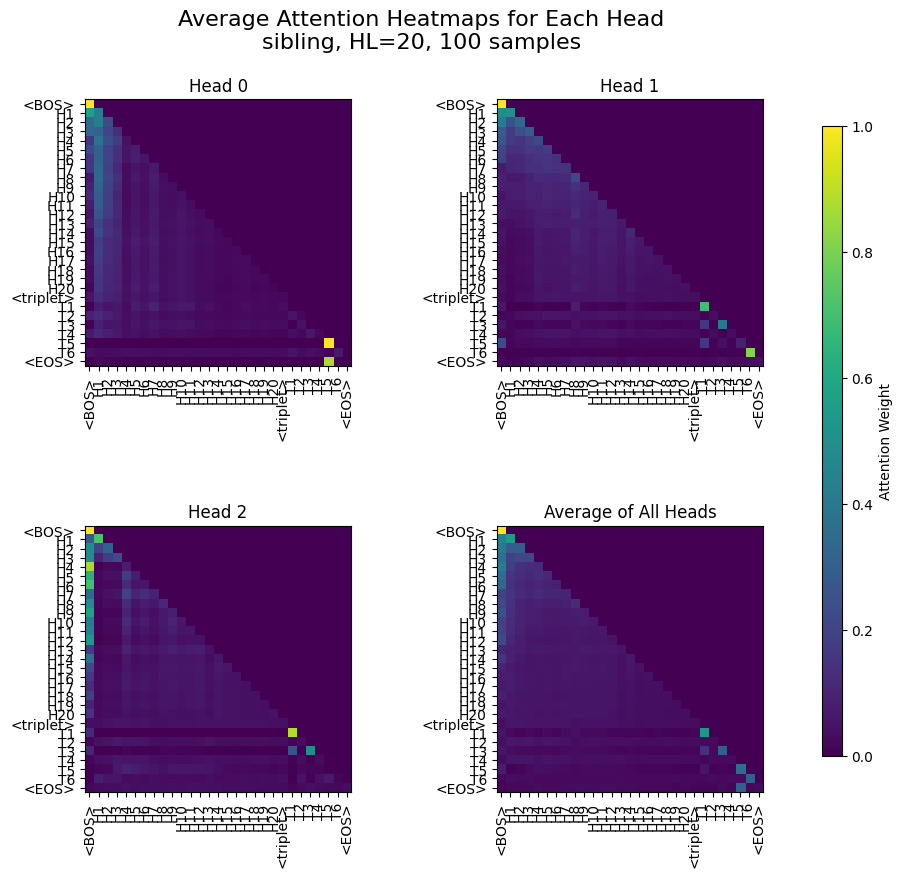

In [21]:
visualize_attention_weights(model, tokenizer, train_dataset, temperature=1.0, step=100, save_path="None", num_samples=100, max_length=100)